# Implementation from Scratch

<br />

I am going to implement algorithms by using the least kinds of libraries such as Numpy possible.

In [23]:
from __future__ import print_function

import random

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

## [Task 1] Create a Class of K-means

<br />

I am going to create a class of K-means that is a nonhierarchical clustering method.

#### Artificial Dataset for Clustering

<br />

I prepare an artificial dataset for the validation of the clustering.

The make_blobs function outputs correct labels, but I do not use them on this task.

In [2]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4,
                  cluster_std=0.5, shuffle=True, random_state=0)

In [3]:
X

array([[ 0.72086751,  3.71347124],
       [-1.89468423,  7.96898545],
       [ 1.35678894,  4.36462484],
       [ 1.05374379,  4.49286859],
       [ 1.59141542,  4.90497725],
       [ 0.78260667,  4.15263595],
       [-1.95751686,  3.87291474],
       [-0.77354537,  7.87923564],
       [ 0.12313498,  5.27917503],
       [-1.43284669,  7.71577043],
       [-0.92819001,  7.02698199],
       [-1.74836345,  7.06307447],
       [-1.26789718,  7.25141327],
       [-0.98661744,  7.74968685],
       [-0.81984047,  7.50994722],
       [ 2.99684287,  0.22378413],
       [ 1.46870582,  1.86947425],
       [-0.33533163,  3.390122  ],
       [-1.86407034,  2.93379754],
       [ 2.62496786,  0.28025075],
       [ 2.11114739,  3.57660449],
       [-1.8219901 ,  7.61654999],
       [-1.91186205,  3.18750686],
       [ 2.28809874,  0.12954182],
       [ 0.5285368 ,  4.49723858],
       [-1.57613028,  2.58614312],
       [-0.565433  ,  3.65813966],
       [ 0.802314  ,  4.38196181],
       [ 2.79939362,

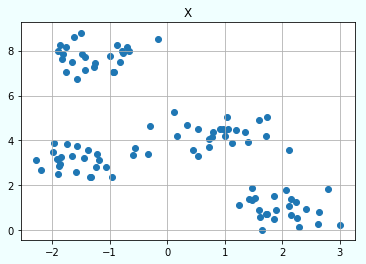

In [4]:
# Plot the dataset

plt.figure(facecolor="azure", edgecolor="coral")
plt.title("X")
plt.grid()

plt.scatter(X[:, 0], X[:, 1])

plt.show()

#### Objective Function

<br />

K-means fit datasets by computing $r_{nk}$ and $\mu$ minimizing SSE, sum of squared errors.

I use this to take the number of clusters, $K$ on the elbow method.

$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$

$n$: index of a data point

$k$: index of a cluster

$X_n$: $n$th data point

$\mu_k$: $k$th central point

$r_{nk}$: 1 if the data point $X_n$ is in the cluster $k$, 0 if not.

#### Fitting

<br />

Basics of fitting by K-means are repeating the following 2 steps.

- Fix central points $\mu_k$ and choose $r_{nk}$ minimalizing SSE.

- Fix the $r_{nk}$ and choose $\mu_k$ minimalizing SSE.

<br />

To be concrete, there are the following steps.

At first, choose initial values of central points $\mu_k$.

Then, repeat the following steps.

- Assign each data point to the most nearest $\mu_k$.

- Transfer the central points $\mu_k$ to mean values (centroids) of all the data points $X_n$ assigned to $k$th cluster.

<br />

Stop the repeating steps if one of the following conditions are verified.

- Iterations reach the number designated before.

- The difference between central points $\mu_k$ and centroids become below an allowance designated before.

- Assigning data points to theirown cluster become not to change.

<br />

In addition,

- Repeat all the steps showed above the number of times designated before.

- Let the smallest SSE the final result of the fitting.

<br />

Finish fitting here.

<br />

We need to think of a possibility that there are spare clusters. To avoid it, implement the following step.

- If there are no data points $X_n$ assigned to $k$th cluster, transfer central point $\mu_k$ to the most farest data point.

#### Euclidean distance

<br />

In terms of K-means, *near* means a value of the Euclidean distance between 2 points is small.

It can be computed by the following equation when I let $p, q$ vectors.

$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$

#### Initial values

<br />

In this task, I will take the most simplest way that I choose k points as initial values randomly from data points $X_n$.

#### Prediction

<br />

When I predict what cluster each new data point belong to, I do the same work with the first phase of fitting.

- On data points $X_n$, I will take centroids $\mu_k$ by fitting and choose $r_{nk}$ minimalizing the SSE.

<br />

To be concrete,

- I will assign each data point to the most nearest $\mu_k$.

In [5]:
# Create a class of K-means from scratch


class ScratchKMeans():
    """
    Implement K-means from scratch.

    Parameters
    ----------
    k: int
        The number of labels

    num_iter: int
        The number of iteration

    Attributes
    ----------
    centroids: ndarray whose shape is (n_features,n_iters)
        K centroids already fitted
    """

    def __init__(self, k, num_iter):
        # Record hyperparameters as attribute
        self.k = k
        self.iter = num_iter

    def fit(self, X):
        """
        Fit datasets by K-means.

        Parameters
        ----------
        X: ndarray whose shape is (n_samples,n_features)
            Features of train dataset
        """

        # Transform arrays to move their features to rows
        X = X.T

        # Set initial central points
        np.random.seed(32)
        index = np.array(range(X.shape[1]))
        np.random.shuffle(index)
        k_index = index[:self.k]
        self.centroids = X[:, k_index]

        # Update the centroids untill they are changing
        for i in range(self.iter):
            cluster_table = self.assign_cluster(X, self.centroids)
            temporary_centroids = self.update_centroids(X, cluster_table)
            if np.allclose(self.centroids, temporary_centroids):
                break
            else:
                self.centroids = temporary_centroids
#                 print("iter:",i)

        # Compute the SSE
        return np.sum(np.square(cluster_table))

    # Compute distances between each point and central points and assign them to theirown label

    def assign_cluster(self, X, centroids):
        """
        Assign each data point to the most nearest cluster.

        Parameters
        ----------
        X: ndarray whose shape is (n_samples,n_features)
            Features of train dataset

        centroids: ndarray whose shape is (n_features,n_iters)
            Initial k centroids

        Returns
        ----------
        cluster_table: ndarray whose shape is (n_samples,n_clusters)
            A table showing what cluster each data point belong to and distances between each data point and the most 
            nearest cluster
        """

        cluster_table = np.zeros((X.shape[1], self.k))
        for i in range(X.shape[1]):
            min_d = 1e+10000
            label = 0
            for j in range(self.k):
                d = np.linalg.norm(X[:, i]-centroids[:, j])
                if d < min_d:
                    min_d = d
                    label = j
            cluster_table[i, label] = min_d

        return cluster_table

    # Update centroids

    def update_centroids(self, X, cluster_table):
        """
        Assign each data point to the most nearest cluster.

        Parameters
        ----------
        X: ndarray whose shape is (n_samples,n_features)
            Features of train dataset

        cluster_table: ndarray whose shape is (n_samples,n_clusters)
            A table showing what cluster each data point belong to and distances between each data point and the most 
            nearest cluster

        Returns
        ----------
        centroids: ndarray whose shape is (n_features,n_iters)
            Updated k centroids
        """

        centroids = np.zeros((2, self.k))
        for i in range(self.k):
            index = np.where(cluster_table[:, i] != 0)
            centroids[0, i] = sum(X[0, index[0]])/len(index[0])
            centroids[1, i] = sum(X[1, index[0]])/len(index[0])

        return centroids

    def predict(self, X):
        """
        Predict datasets by K-means.

        Parameters
        ----------
        X: ndarray whose shape is (n_samples,n_features)
            Features of train dataset

        Returns
        ----------
        y_pred: ndarray whose shape is (n_samples,n_clusters)
            A table showing what cluster each data point belong to and distances between each data point and the most 
            nearest cluster
        """

        # Transform arrays to move their features to rows
        X = X.T

        # Return a cluster table
        return self.assign_cluster(X, self.centroids)

    # Implement the Elbow method

    def elbow_method(self, X, kinds_of_clusters):
        """
        Implement the Elbow method.

        Parameters
        ----------
        X: ndarray whose shape is (n_samples,n_features)
            Features of train dataset

        kinds_of_clusters: int
            The number of kinds of clusters
        """

        k_list = []
        sse_list = []
        for i in range(kinds_of_clusters+1):
            kmeans = ScratchKMeans(i+1, 100)
            sse = kmeans.fit(X)
            k_list.append(i+1)
            sse_list.append(sse)

        plt.figure(facecolor="azure", edgecolor="coral")
        plt.grid(True)

        plt.plot(k_list, sse_list)

        plt.title("Elbow Method")
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")

        plt.show()

In [6]:
# Initialize the class

kmeans = ScratchKMeans(13, 100)

In [7]:
# Fitting

kmeans.fit(X)

22.208689719369755

## [Task 2] Implement Elbow method

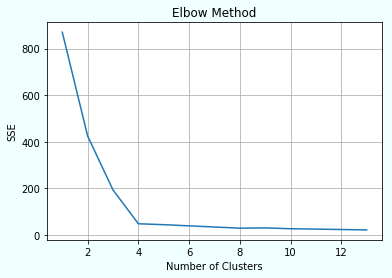

In [8]:
# Plot a graph of the Elbow method

kmeans.elbow_method(X, 12)

## [Task 3] Silhouette Plot

#### Sihouette Coefficient

<br />

$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$

$a_n$ : Mean of distances between a data point and others in a same cluster

$b_n$ : Mean of distances between a data point in a cluster and all data points in the most nearest other clusters.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.570301896345626
For n_clusters = 3 The average silhouette_score is : 0.6356855448662441
For n_clusters = 4 The average silhouette_score is : 0.7083987104616173
For n_clusters = 5 The average silhouette_score is : 0.614779893203811
For n_clusters = 6 The average silhouette_score is : 0.5169928723193439


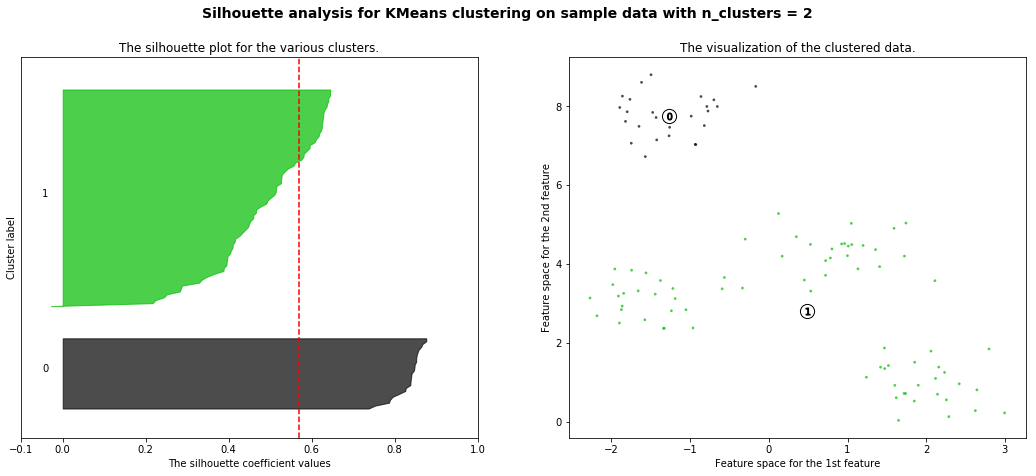

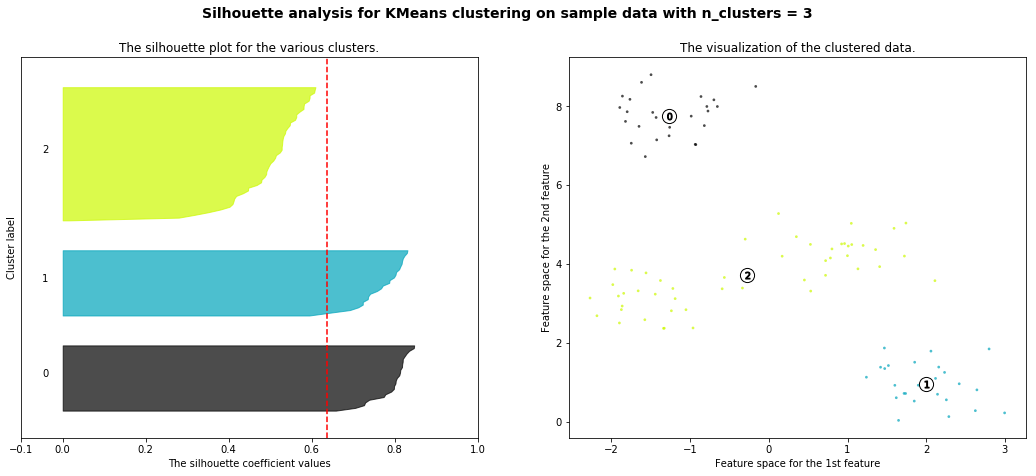

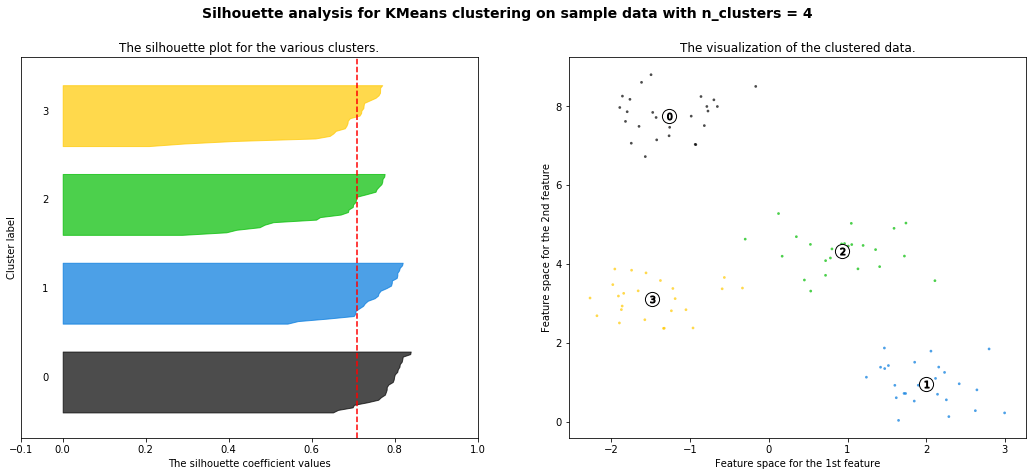

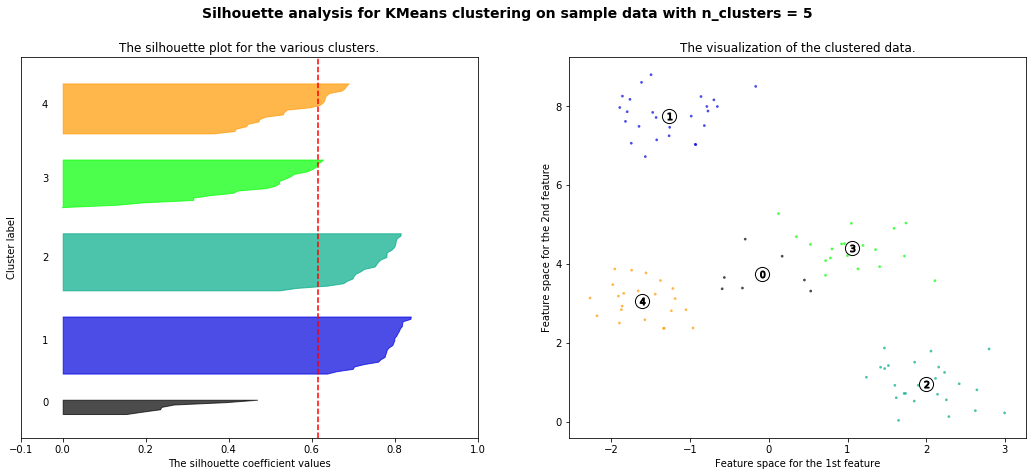

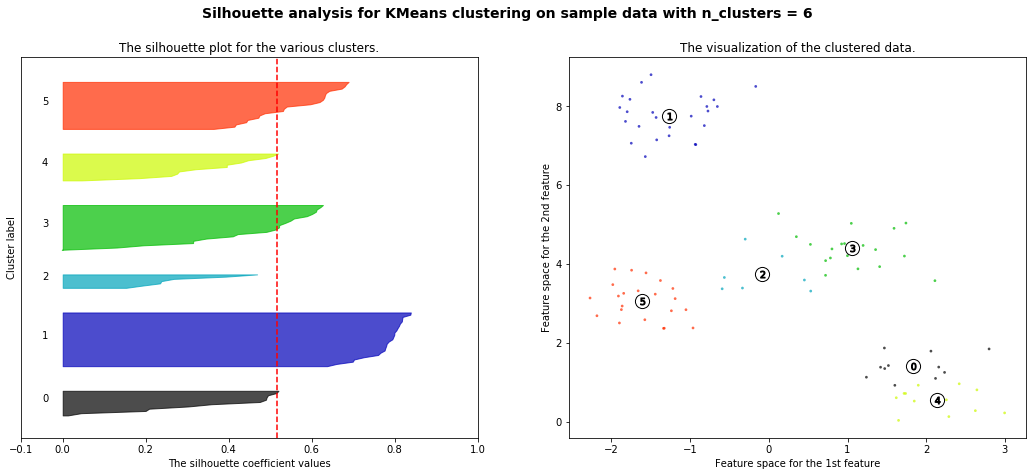

In [21]:
# Another way

print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Clustering Analysis

#### Data Analysis for Wholesalers

<br />

I am going to use the "Wholesale customers Data Set" file to learn about how to use clustering.

The dataset is that a wholesaler in Lisbon, Portugal collected data from its customers.

It shows how much Euros each customer buy any products such as milk and food per year.

Customers include retail stores and restaurants.

In [9]:
# Import the csv file

df = pd.read_csv("wholesale-customers-data.csv")

In [10]:
# Check the contents

df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


#### Dimention Reduction

<br />

There are 6 features about costs, so I will reduce the dimentions to visualize the data.

In [11]:
# Delete 2 features, Channel and Region

new_df = df.drop(["Channel", "Region"], axis=1)

In [12]:
# PCA

pca = PCA(n_components=2)
pca = pca.fit(new_df)
new_df_pca = pca.transform(new_df)

In [13]:
# Check the PCA

new_df_pca

array([[ 6.50022122e+02,  1.58551909e+03],
       [-4.42680498e+03,  4.04245151e+03],
       [-4.84199871e+03,  2.57876218e+03],
       [ 9.90346437e+02, -6.27980600e+03],
       [ 1.06579987e+04, -2.15972582e+03],
       [-2.76596159e+03, -9.59870727e+02],
       [-7.15550892e+02, -2.01300227e+03],
       [-4.47458367e+03,  1.42949697e+03],
       [-6.71209540e+03, -2.20590916e+03],
       [-4.82363435e+03,  1.34805592e+04],
       [-7.97482898e+03,  5.71121893e+03],
       [ 3.63937790e+01, -6.03789641e+03],
       [ 1.99402021e+04,  4.59128648e+03],
       [ 9.39669558e+03,  5.91315704e+03],
       [ 1.26603704e+04,  4.54194543e+03],
       [-2.99772590e+03, -6.09387930e+03],
       [-1.05895236e+04,  6.58421594e+03],
       [-6.36709518e+03, -3.68071267e+03],
       [ 6.62382534e+03,  1.25471953e+03],
       [-4.86153157e+03, -2.25592266e+02],
       [ 4.79424416e+03, -3.98879936e+03],
       [-7.24486684e+03, -7.34772325e+03],
       [ 1.92992657e+04, -6.93681068e+03],
       [ 1.

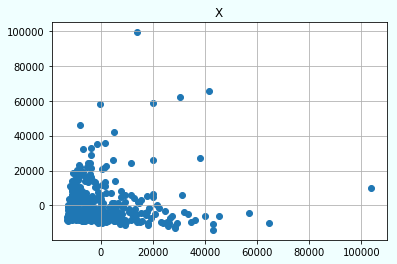

In [14]:
# Plot the PCA data

plt.figure(facecolor="azure", edgecolor="coral")
plt.title("X")
plt.grid()

plt.scatter(new_df_pca[:, 0], new_df_pca[:, 1])

plt.show()

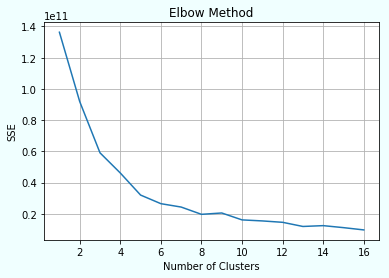

In [15]:
# Plot a graph of the Elbow method

kmeans.elbow_method(new_df_pca, 15)

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


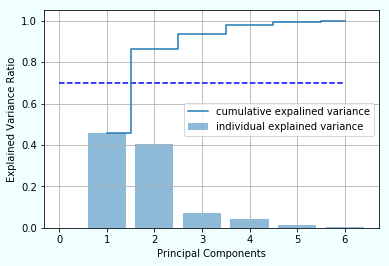

In [16]:
# Draw a graph of explained variance ratios of PCA

pca = PCA(n_components=None)
pca = pca.fit(new_df)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

plt.figure(facecolor="azure", edgecolor="coral")
plt.bar(range(1, 7), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 7), cum_var_exp, where='mid',
         label='cumulative expalined variance')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')

plt.hlines(0.7, 0, 6, "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()

plt.show()

## [Task 4] Choose the Number of Clusters

    - I let k 4.

    - The reason why I let k 4 is that the silhouette plot where the number of clusters is 4 shows that the silhouette coefficients of all clusters are more than the mean. Also, the sums of samples of each cluster are almost same.

## [Task 5] Compare the PCAed Data about Costs with the Other Known Data

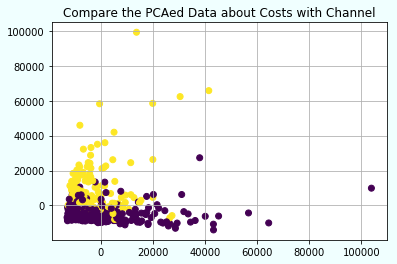

In [17]:
# Plot the PCAed data about costs by comparing with the "Channel" data

plt.figure(facecolor="azure", edgecolor="coral")
plt.title("Compare the PCAed Data about Costs with Channel")
plt.grid()

plt.scatter(new_df_pca[:, 0], new_df_pca[:, 1], c=df.Channel)

plt.show()

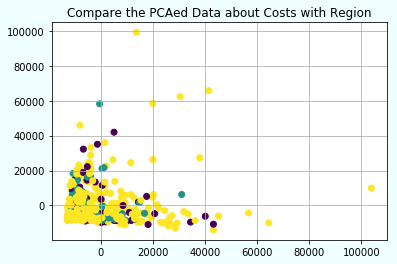

In [18]:
# Plot the PCAed data about costs by comparing with the "Region" data

plt.figure(facecolor="azure", edgecolor="coral")
plt.title("Compare the PCAed Data about Costs with Region")
plt.grid()

plt.scatter(new_df_pca[:, 0], new_df_pca[:, 1], c=df.Region)

plt.show()

    - The data of "Channel" and "Region" are categorical while the other 6 datas are quantitative.

In [24]:
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(new_df_pca)

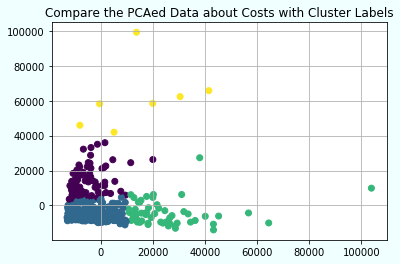

In [26]:
# Plot the PCAed data about costs by comparing with cluster labels

plt.figure(facecolor="azure", edgecolor="coral")
plt.title("Compare the PCAed Data about Costs with Cluster Labels")
plt.grid()

plt.scatter(new_df_pca[:, 0], new_df_pca[:, 1], c=cluster_labels)

plt.show()

    - Clustered data is classified very well.

## [Task 6] Meaningful Information for Wholesalers

In [19]:
# Check the contents

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Attribute Information:

1. FRESH: annual spending (m.u.) on fresh products (Continuous)

1. MILK: annual spending (m.u.) on milk products (Continuous)

1. GROCERY: annual spending (m.u.)on grocery products (Continuous)

1. FROZEN: annual spending (m.u.)on frozen products (Continuous)

1. DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)

1. DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)

1. CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)

1. REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [21]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [22]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [23]:
# "Channel" frequency

print("1: Horeca")
print("2: Retail")

df.Channel.value_counts()

1: Horeca
2: Retail


1    298
2    142
Name: Channel, dtype: int64

In [24]:
# "Region" frequency

print("1: Lisbon")
print("2: Oporto")
print("3: Other Region")

df.Region.value_counts()

1: Lisbon
2: Oporto
3: Other Region


3    316
1     77
2     47
Name: Region, dtype: int64

    - The data of "Other Region" is too much and meaningless.

In [25]:
# By categorical data

grouped = df.groupby(["Channel", "Region"])

In [26]:
grouped.sum()

Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
Channel Region                                                        
1       1        761233   228342   237542  184512             56081   
        2        326215    64519   123074  160861             13516   
        3       2928269   735753   820101  771606            165990   
2       1         93600   194112   332495   46514            148055   
        2        138506   174625   310200   29271            159795   
        3       1032308  1153006  1675150  158886            724420   

                Delicassen  
Channel Region              
1       1            70632  
        2            30965  
        3           320358  
2       1            33695  
        2            23541  
        3           191752

    - Because of the "Other Region" data, thinking of those sums is not useless.

In [27]:
grouped.mean()

Fresh          Milk       Grocery       Frozen  \
Channel Region                                                          
1       1       12902.254237   3870.203390   4026.135593  3127.322034   
        2       11650.535714   2304.250000   4395.500000  5745.035714   
        3       13878.052133   3486.981043   3886.734597  3656.900474   
2       1        5200.000000  10784.000000  18471.944444  2584.111111   
        2        7289.789474   9190.789474  16326.315789  1540.578947   
        3        9831.504762  10981.009524  15953.809524  1513.200000   

                Detergents_Paper   Delicassen  
Channel Region                                 
1       1             950.525424  1197.152542  
        2             482.714286  1105.892857  
        3             786.682464  1518.284360  
2       1            8225.277778  1871.944444  
        2            8410.263158  1239.000000  
        3            6899.238095  1826.209524

    - Customers who watch the "Horeca" channel tend to buy "Fresh" much more than customers who watch the "Retail" channel.
    
    - Customers who watch the "Horeca" channel tend to buy "Milk", "Grocery" and "Detergents_Paper" much less than customers who watch the "Retail" channel.

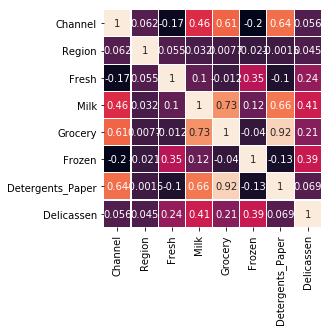

In [28]:
# Plot the heatmap

df_corr = df.corr()

sns.heatmap(df_corr, annot=True, square=True, linewidths=0.1, cbar=False)

plt.show()

    - There are 2 strong correlations between "Milk" and "Grocery", and "Milk" and "Detergents_Paper". These features are necessary on our daily life, so I can understand the 2 strong correlations.
    
    - Also, correlations of "Channel" with "Grocery" and "Detergents_Paper" are strong.
     
    - A correlation between "Grocery" and "Detergents_Paper" is too strong. It is very useless.

In [29]:
# Substitute real names to theirown categorical data

df.loc[df["Channel"] == 1, "Channel"] = "Horeca"
df.loc[df["Channel"] == 2, "Channel"] = "Retail"

df.loc[df["Region"] == 1, "Region"] = "Lisbon"
df.loc[df["Region"] == 2, "Region"] = "Oporto"
df.loc[df["Region"] == 3, "Region"] = "Other Region"

In [30]:
# Check the substitution

df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,12669,9656,7561,214,2674,1338
1,Retail,Other Region,7057,9810,9568,1762,3293,1776
2,Retail,Other Region,6353,8808,7684,2405,3516,7844
3,Horeca,Other Region,13265,1196,4221,6404,507,1788
4,Retail,Other Region,22615,5410,7198,3915,1777,5185
5,Retail,Other Region,9413,8259,5126,666,1795,1451
6,Retail,Other Region,12126,3199,6975,480,3140,545
7,Retail,Other Region,7579,4956,9426,1669,3321,2566
8,Horeca,Other Region,5963,3648,6192,425,1716,750
9,Retail,Other Region,6006,11093,18881,1159,7425,2098


/Users/kazukiegusa/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


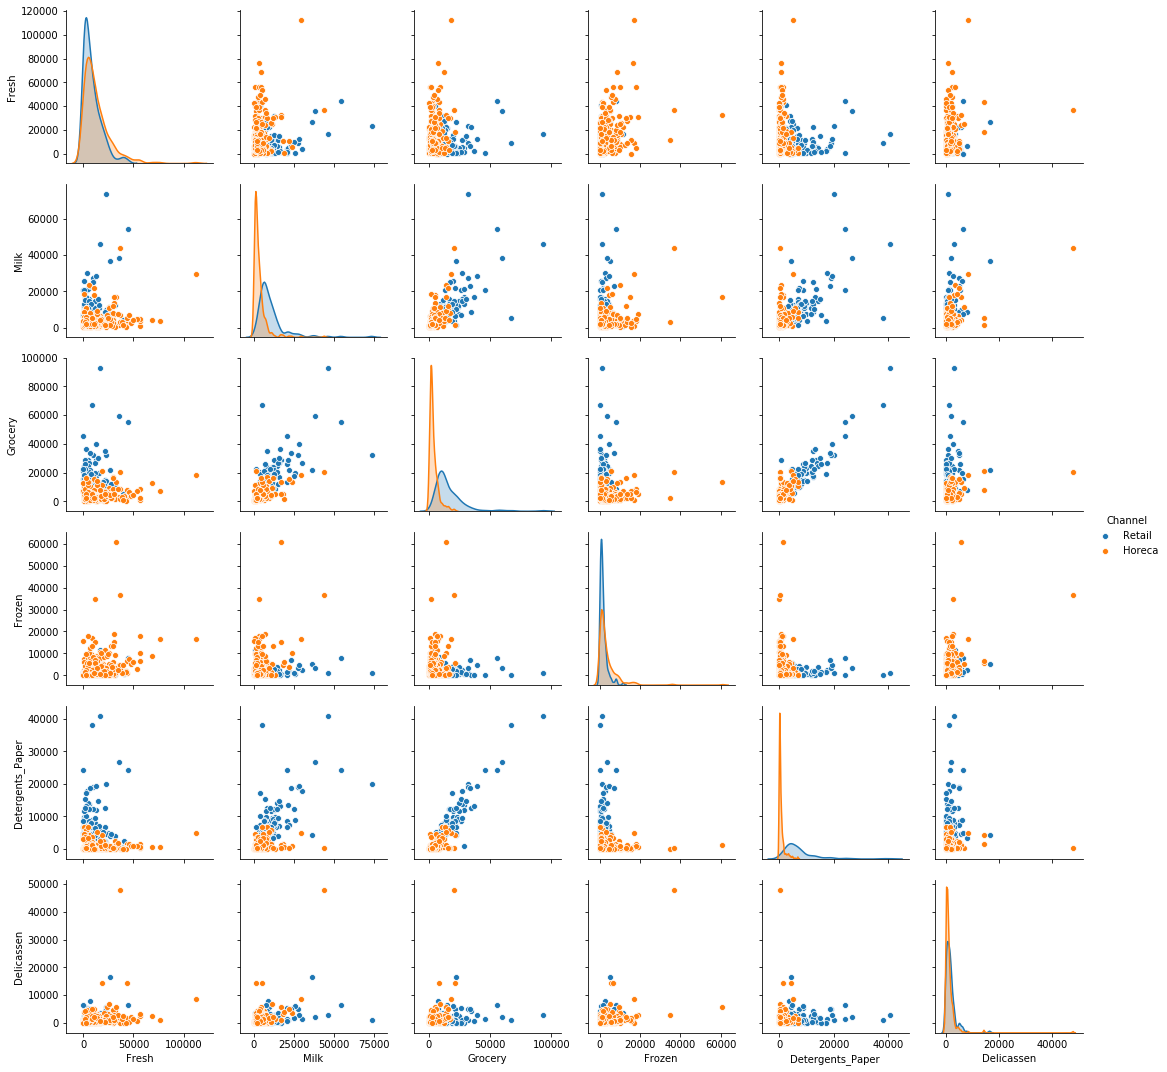

In [31]:
# Plot the pairplot by focusing on "Channel"

sns.pairplot(df, hue="Channel")

plt.show()

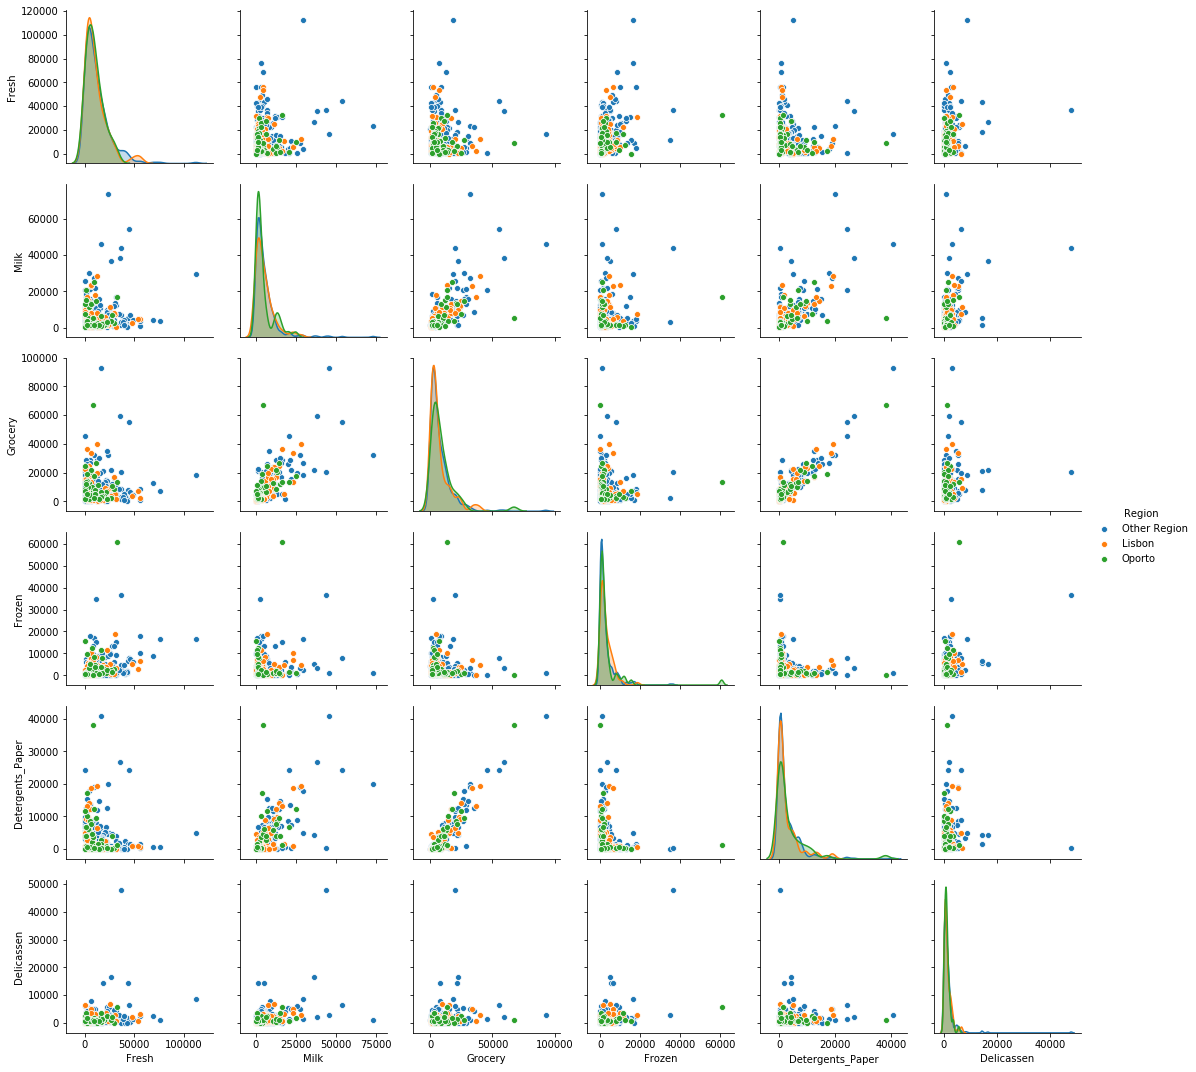

In [32]:
# Plot the pairplot by focusing on "Channel"

sns.pairplot(df, hue="Region")

plt.show()

# Other Kinds of Non-hierarchical Clustering Methods

## [Task 7] Other Kinds of Methods

- DBSCAN as Non-hierarchical clustering method

    - 

- t-SNE and LLE as dimention reduction method

    - 

## [Task 8] Use of t-SNE and DBSCAN

# Discussion

## [Task 9] Unsupervised Learning and Supervised Learning

    - The main difference between unsupervied learning and supervised learning is that unsupervised leaning does not have specific labels while supervised learning has.
    
    - Supervised learning requires both of explanatory and objective variances while unsupervised learning does not.
    
    - Supervised learning is affected by too much similar data, but unsupervised learning can be applied to unbalanced data.
    
    - We need to analyze results of unsupervised learning carefully because it does not have any specific labels.